# Multiclass classification with 2 features using trees

Classification trees are a wide category of algorithms to process classification (and linear regression).

In this notebook, we will reuse the generated dataset of the multiclass linear regression with Keras ([HTML](ClassificationMulti2Features-Keras.html) / [Jupyter](ClassificationMulti2Features-Keras.ipynb)) : the Czech and Norvegian flags.

Learning goals:
- Theory of trees
- Custom code for trees
- Understanding of the tree partitioning and performance
- Decision tree using Scikit-Learn model

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as pltcolors
from sklearn import metrics, tree
import graphviz
from IPython.display import SVG
import seaborn as sns

## Helpers

In [32]:
def flagPlot(X, y, title, colors, ax=None):
    """ Plot the flag as a 2D parametric label"""
    if ax is None:
        ax = plt.gca()
    ax.set_facecolor((0.8, 0.8, 0.8))
    f = ax.scatter(X[:,0], X[:,1], c=y, cmap=pltcolors.ListedColormap(colors), marker='x', alpha=0.5);
    ax.set_xlabel('$x_0$')
    ax.set_ylabel('$x_1$')
    ax.grid()
    ax.set_title(title)
    cb = plt.colorbar(f, ax=ax)
    loc = np.arange(0,2.1,1)
    cb.set_ticks(loc)
    cb.set_ticklabels([0,1,2]);
    
def plotHeatMap(X, classes, title=None, fmt='.2g', ax=None, xlabel=None, ylabel=None):
    """ Fix heatmap plot from Seaborn with pyplot 3.1.0, 3.1.1
        https://stackoverflow.com/questions/56942670/matplotlib-seaborn-first-and-last-row-cut-in-half-of-heatmap-plot
    """
    ax = sns.heatmap(X, xticklabels=classes, yticklabels=classes, annot=True, fmt=fmt, cmap=plt.cm.Blues, ax=ax) #notation: "annot" not "annote"
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    if title:
        ax.set_title(title)
    if xlabel:
        ax.set_xlabel(xlabel)
    if ylabel:
        ax.set_ylabel(ylabel)
        
def plotConfusionMatrix(yTrue, yEst, classes, title=None, fmt='.2g', ax=None):
    plotHeatMap(metrics.confusion_matrix(yTrue, yEst), classes, title, fmt, ax, xlabel='Estimations', ylabel='True values');

## Data models - Flags

In [3]:
nFeatures = 2
nClasses = 3

In [4]:
# Czech flag colors
czechColors = np.array(['blue', 'red', 'white'])
def generateCzechBatch(n, noiseSigma = 0.1):
    """ Generate a multi class sample based on the Czech banner geometry. 
        Tip of the triangle is set at the origin 
    """
    # xMax adjusted such that the 3 classes are quasi equiprobable
    xMin = np.array([-1, -1])
    xMax = np.array([0.5, 1])
    #
    X = np.random.uniform(xMin, xMax, (n, nFeatures))
    noisyX = X + np.random.normal(0, noiseSigma, X.shape)
    y = np.zeros(n)
    y[noisyX[:,1] > 0]  = 2                                       # White
    y[noisyX[:,1] <= 0] = 1                                       # Red
    y[(noisyX[:,0] <= 0) & (np.abs(noisyX[:,1]) < np.abs(noisyX[:,0]))] = 0 # Blue triangle
    return X, y

In [34]:
# Norway flag colors
norwayColors = ['red', 'white', 'navy']
def generateNorwayBatch(n, noiseSigma = 0.1):
    """ Generate a multi class sample based on the Norway banner geometry """
    # xMax adjusted such that the 3 classes are quasi equiprobable
    xMin = np.array([-1, -1])
    xMax = np.array([1, 1])
    #
    X = np.random.uniform(xMin, xMax, (n, nFeatures))
    a1 = 0.43
    a2 = 0.18
    noisyX = X + np.random.normal(0, noiseSigma, X.shape)
    y = np.zeros(n)                                                                # Red = background
    y[((noisyX[:,0] > -a1) & (noisyX[:,0] < a1)) | ((noisyX[:,1] > -a1) & (noisyX[:,1] < a1))]  = 1    # White cross
    y[((noisyX[:,0] > -a2) & (noisyX[:,0] < a2)) | ((noisyX[:,1] > -a2) & (noisyX[:,1] < a2))]  = 2    # Navy cross over white
    return X, y

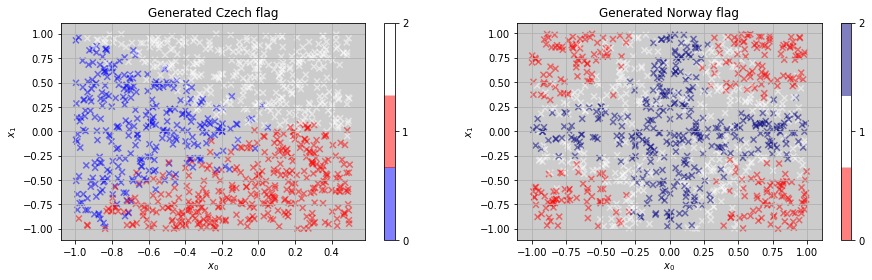

In [33]:
N = 1000
xTrainC, yTrainC = generateCzechBatch(N)
fig, axes = plt.subplots(1, 2, figsize=(15,4))
flagPlot(xTrainC, yTrainC, 'Generated Czech flag', czechColors, axes[0])
xTrainN, yTrainN = generateNorwayBatch(N)
flagPlot(xTrainN, yTrainN, 'Generated Norway flag', norwayColors, axes[1])

### Test data

In [7]:
xTestC, yTestC = generateCzechBatch(N)
xTestN, yTestN = generateNorwayBatch(N)

## Tree classifier

Tree classifiers are a very large family of non-parametric classifiers, and have many refinements. They are splitting recursively a portion of the space with an hyperplan. 

In our case, the space is 2 dimension, the splitting hyperplan is thus 1D : a line. 

We will first implement a tree classifier from scratch, then use the Scikit-Learn implementation.

Trees main advantages are :
- Better ability to approximate complex functions than linear regression
- Explanability of the decisions since the boundaries are known. However, the decisions might have no human understanding
- Far more efficient than the kNN classifier ([HTML](ClassificationContinuous2Features-KNN.html) / [Jupyter](ClassificationContinuous2Features-KNN.ipynb)) since the model is fitted only once

Their main drawbacks : 
- Cost and difficulty to reach the optimum. We will see later the Random Forest method that is mitigating this issue

### Algorithm

We will use a simple recursive split algorithm similar to CART. 

At each iteration of the split :
- Select the feature (co-variable) bringing the best improvement on the impurity (also known as information gain)
- Split the space with an hyperplan orthogonal to that feature's axis

For simplification purpose, following algo choices are set:
- Impurity improvement is measured as entropy minimization, other metrics are often in use like Gini
- Split is at the middle point of the axis, finer grain split is possible
- Partitioning stop condition is on the leaf minimum item number and the minimum entropy

Impurity is calculated as the average of the entropies of the two partitions created by the split, weighted by the number of items in each partition.

Entropy is defined using the empirical probabilities of the $Y$ labels within each classes : 
$$ - \sum_{c \in C} \mathbb{P}(y=c) log(\mathbb{P}(y=c))$$

$C$ is the set of classes in $Y$, in our case $ C = \{0, 1, 2\}$ or the set of three colors.


### References

- [Decision Tree tutorial at Analytics Vidhya](https://www.analyticsvidhya.com/blog/2016/04/complete-tutorial-tree-based-modeling-scratch-in-python/#three)
- [Let’s Write a Decision Tree Classifier from Scratch - Machine Learning Recipes #8 - Youtube](https://www.youtube.com/watch?v=LDRbO9a6XPU)

## Home made implementation

During training, the classifier algorithm is partitioning the original X space and producing a tree representing this partitioning.

Two Python classes are designed :
- The classifier _MyTreeClassifier_
- The tree element _TreeNode_ that may be intermediate or terminal. Intermediate nodes have two children

The algorithm used for the partitioning is quite naive as it heavily uses numpy slicing based on range inequalities. 

In [8]:
class TreeNode:
    """ Tree node element
        Either an intermediate node with two children (left-right) or a leaf node
    """
    
    def __init__(self, depth, parent, boundary, entropy):
        self.depth = depth
        self.parent = parent
        self.boundary = boundary
        self.splitOnFeature = None
        self.halfPoint = None
        self.entropy = entropy
        self.leftChild = None
        self.rightChild = None
        self.valueFrequencies = None
        self.isLeaf = False
        
    def split(self, splitOnFeature, halfPoint, childL, childR, valueFrequencies=None):
        """ Split node into to two child nodes """
        self.splitOnFeature = splitOnFeature
        self.halfPoint = halfPoint
        self.leftChild = childL
        self.rightChild = childR
        self.valueFrequencies = valueFrequencies
   
    def setAsLeaf(self, valueFrequencies):
        """ Set this node to be a terminal (a leaf) """
        self.valueFrequencies = valueFrequencies
        self.isLeaf = True
        
    def predict(self, x):
        """ Recursively predict value """
        if len(x.shape) > 1:
            if self.isLeaf:
                return self.getValue() * np.ones(x.shape[0])
            else:
                result = np.zeros(x.shape[0])
                left = (x[:,self.splitOnFeature] <= self.halfPoint)
                result[left] = self.leftChild.predict(x[left])
                result[~left] = self.rightChild.predict(x[~left])
                return result
        else:
            if self.isLeaf:
                return self.getValue()
            elif(x[self.splitOnFeature] > self.halfPoint):
                return self.rightChild.predict(x)
            else:
                return self.leftChild.predict(x)

    def getValue(self):
        """ Take the class with highest frequency as value """
        return np.argmax(self.valueFrequencies)

In [9]:
class MyTreeClassifier:
    """ Tree classifier using CART recursive algorithm 
        Stop criteria are the leaf minimum number of items, and the minimum entropy
        Entropy is used to measure the impurity
    """

    def __init__(self, leafMinSize=5, entropyMin=1e-5):
        self.leafMinSize = leafMinSize
        self.entropyMin = entropyMin
        self.root = None

    def fit(self, X, y, yClasses=None):
        """ Partition X partition in order to predict y """
        if not yClasses:
            yClasses = np.unique(y)
        p = X.shape[1]
        # Stack X and y in order to extract slices
        Xy = np.hstack((X, y.reshape(-1, 1)))
        # Get overall X bounding box
        epsilon = 1e-4
        originalBoundary = [[X[:,j].min() - epsilon, X[:,j].max()] for j in range(p)]
        
        # Initialize FIFO of sub-partitions to split, 
        #  it avoids recursive calls with large sub-partitions in memory
        self.root = TreeNode(0, None, originalBoundary, self.getEntropy(y, yClasses))
        splitList = [(Xy, self.root)]
        processedList = []

        # Run until splitList FIFO empty
        while splitList:
            partition, node = splitList.pop(0)
            selectedFeature, halfPoint, newBoundary, entropies = \
                self.splitDecision(partition, node.boundary, yClasses)
            partitionValue = self.getValueFrequencies(partition[:,nFeatures], len(yClasses))
            
            # Split
            children  = [TreeNode(node.depth + 1, node, newBoundary[i], entropies[i]) for i in range(2)]
            node.split(selectedFeature, halfPoint, children[0], children[1], partitionValue)
            processedList.append(node)
            
            # (Schedule) process of children
            for child, bound, entropy in zip(children, newBoundary, entropies):
                subpartition = self.selectSubPartition(partition, bound)
                if (len(subpartition) > self.leafMinSize) and (entropy > self.entropyMin):
                    splitList.append((subpartition, child))
                else:
                    child.setAsLeaf(self.getValueFrequencies(subpartition[:,nFeatures], len(yClasses)))
                    processedList.append(child)
        return processedList
      
    def predict(self, X):
        """ Predict y values given X """
        assert(self.root != None)
        return self.root.predict(X)   

    def splitDecision(self, Xy, xBoundary, yClasses):
        """ Select variable axis to be split computing impurity """
        p = len(xBoundary)
        nTotal = len(Xy)
        # Distribution after split
        halfPoints = [(xBoundary[i][0] + xBoundary[i][1])/2 for i in range(nFeatures)]
        impurity = []
        entropies = []
        for xIndex in range(nFeatures):
            xRangeLeft  = (Xy[:,xIndex] > xBoundary[xIndex][0]) & (Xy[:,xIndex] <= halfPoints[xIndex])
            xRangeRight = (Xy[:,xIndex] > halfPoints[xIndex]) & (Xy[:,xIndex] <= xBoundary[xIndex][1])
            weightedEntropies = []
            for ra in [xRangeLeft, xRangeRight]:
                partitionHalf  = Xy[ra]
                nPartition  = len(partitionHalf)
                if nPartition > 0:
                    entropy = self.getEntropy(partitionHalf[:,nFeatures], yClasses)
                    entropies.append(entropy)
                    weightedEntropies.append(entropy * nPartition)
                else:
                    entropies.append(0)
            impurity.append(np.sum(weightedEntropies) / nTotal)
        # Select the feature to split that is leading to the lowest impurity
        selectedFeature = np.argmin(impurity)
        newBoundary = [[[xBoundary[i][0], halfPoints[i] if i == selectedFeature else xBoundary[i][1]] \
                        for i in range(nFeatures)],
                      [[halfPoints[i] if i == selectedFeature else xBoundary[i][0], xBoundary[i][1]] \
                        for i in range(nFeatures)]]
        return selectedFeature, halfPoints[selectedFeature], newBoundary, \
            entropies[selectedFeature*2:(selectedFeature+1)*2]
    
    def getEntropy(self, y, yClasses):
        """ Compute entropy given the empirical probabilities for each class"""
        nPartition = len(y)
        frequencies = np.array([np.sum(y == c) / nPartition for c in yClasses])
        # epsilon added to avoid log of 0
        epsilon = 1e-10
        return - np.sum(np.dot(frequencies, np.log(frequencies + epsilon)))

    def selectSubPartition(self, Xy, xBoundary):
        """ Select a rectangular sub-partition """
        p = len(xBoundary)
        xRanges = [(Xy[:,j] > xBoundary[j][0]) & (Xy[:,j] <= xBoundary[j][1]) for j in range(p)]
        return Xy[xRanges[0] & xRanges[1]]
    
    def getValueFrequencies(self, y, nClasses):
        binEdges = np.arange(nClasses + 1) - 0.5
        return np.histogram(y, bins=binEdges)[0]

### Model Fit on Czech and Norway flags

In [35]:
model0Czech = MyTreeClassifier()
processedListC = model0Czech.fit(xTrainC, yTrainC, range(3))

In [11]:
model0Norway = MyTreeClassifier()
processedListN = model0Norway.fit(xTrainN, yTrainN, range(3))

### Analysis and evaluation

#### Plot tree partitioning

In [12]:
def plotNodeArea(node, palette, ax):
    """ Plot the area and split line of a tree node """
    color = palette[int(np.round(node.getValue()))]
    ax.fill_between(node.boundary[0], node.boundary[1][0], node.boundary[1][1], color=color)
    if node.halfPoint:
        if node.splitOnFeature == 0:
            return ax.plot(np.ones(2) * node.halfPoint, node.boundary[1], color='k')
        else:
            return ax.plot(node.boundary[0], np.ones(2) * node.halfPoint, color='k')

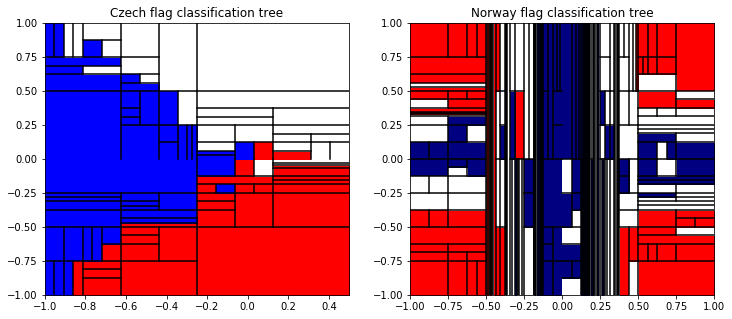

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
for ax, processedList, palette in zip(axes, [processedListC, processedListN], [czechColors, norwayColors]):
    ax.set_facecolor((0.8, 0.8, 0.8))
    for targetDepth in range(1, 10):
        for n in filter(lambda n: n.depth == targetDepth, processedList):
            plotNodeArea(n, palette, ax)

axes[0].set_title("Czech flag classification tree")
axes[0].set_xlim(-1, 0.5)
axes[0].set_ylim(-1, 1);
axes[1].set_title("Norway flag classification tree")
axes[1].set_xlim(-1, 1)
axes[1].set_ylim(-1, 1);

The Czech flag is quite homogeneous within the three color areas. Challenges are the color area boundaries where the gaussian noise is mixing color points, and the diagonal boundaries that mus be approximated by small rectangles.

The Norway flag is more complex because of the small width of the white area. Noise is also adding some challenges. We observe that the partitioning is not similar on the four quadrants.

### Weighted entropy plot for Norway flag

All along the tree fit, the weighted entropy is computed for each split area (left / right).

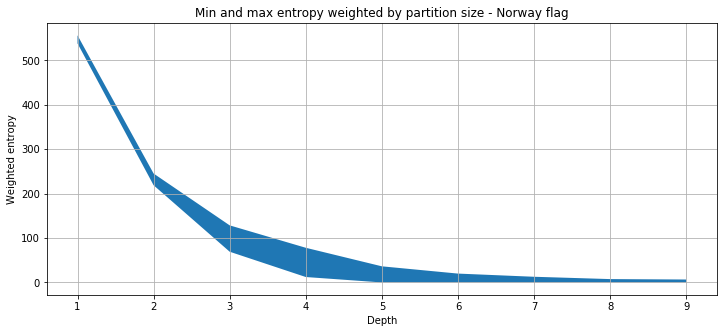

In [24]:
def getMinMaxEntropies(nodeList, depthRange):
    weithedEntropiesMin = []
    weithedEntropiesMax = []
    for targetDepth in depthRange:
        weithedEntropies = np.array([node.entropy * np.sum(node.valueFrequencies) for node in filter(lambda n: n.depth == targetDepth, nodeList)])
        weithedEntropiesMin.append(weithedEntropies.min())
        weithedEntropiesMax.append(weithedEntropies.max())
    return weithedEntropiesMin, weithedEntropiesMax

depthRange = range(1, 10)
entropiesMin, entropiesMax = getMinMaxEntropies(processedListN, depthRange)
fig, ax = plt.subplots(1, 1, figsize=(12, 5))
ax.fill_between(depthRange, entropiesMin, entropiesMax)
ax.set_xlabel("Depth")
ax.set_ylabel("Weighted entropy")
ax.set_title("Min and max entropy weighted by partition size - Norway flag")
ax.grid()

#### Czech flag classifier performance

              precision    recall  f1-score   support

         0.0       0.86      0.89      0.88       336
         1.0       0.93      0.91      0.92       328
         2.0       0.92      0.90      0.91       336

    accuracy                           0.90      1000
   macro avg       0.90      0.90      0.90      1000
weighted avg       0.90      0.90      0.90      1000



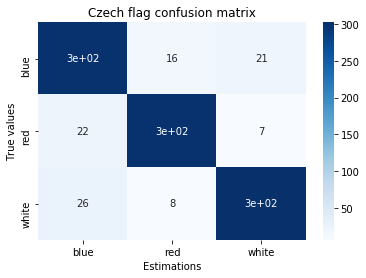

In [15]:
yEstC = model0Czech.predict(xTestC)
plotConfusionMatrix(yTestC, yEstC, czechColors, title="Czech flag confusion matrix")
print(metrics.classification_report(yTestC, yEstC))

#### Norway flag classifier performance

              precision    recall  f1-score   support

         0.0       0.80      0.84      0.82       319
         1.0       0.59      0.62      0.61       366
         2.0       0.71      0.64      0.67       315

    accuracy                           0.70      1000
   macro avg       0.70      0.70      0.70      1000
weighted avg       0.70      0.70      0.70      1000



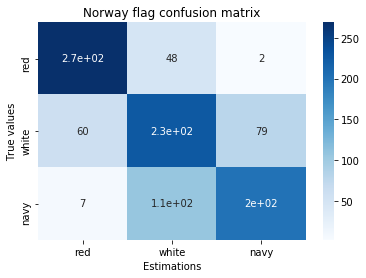

In [16]:
yEstN = model0Norway.predict(xTestN)
plotConfusionMatrix(yTestN, yEstN, norwayColors, title="Norway flag confusion matrix")
print(metrics.classification_report(yTestN, yEstN))

Norway flag problem is a little more challenging as the there are more borders between the three colors.

Let's investigate the best parameters using accuracy

### Hyper-parameter search using grid on Norway flag

A grid search is performed on the two tree partitioner stop conditions : on minimum impurity, and on minimum leave size

In [17]:
leafSizeRange = range(4, 21)
entropyRange = np.logspace(-3, 0, 10)
accuracy = np.zeros((len(leafSizeRange), len(entropyRange)))
for i,leafMinSize in enumerate(leafSizeRange):
    for j,entropy in enumerate(entropyRange): 
        model1Norway = MyTreeClassifier(leafMinSize=leafMinSize, entropyMin=entropy)
        model1Norway.fit(xTrainN, yTrainN, range(3))
        yEstN1 = model1Norway.predict(xTestN)
        accuracy[i,j] = np.mean(yEstN1 == yTestN)

bestParams = np.argmax(accuracy)

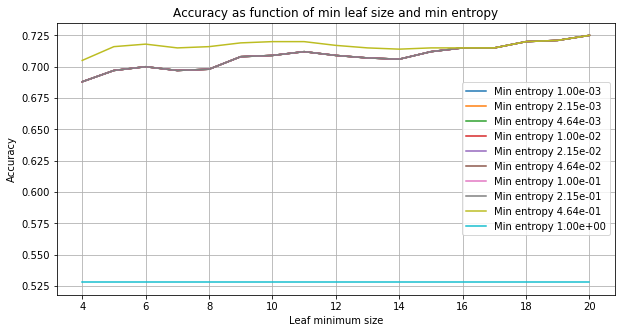

In [18]:
fig, ax = plt.subplots(1, figsize=(10, 5))
for j,h in enumerate(entropyRange):
    ax.plot(leafSizeRange, accuracy[:,j], label = "Min entropy %.2e" % h)
ax.legend()
ax.set_title("Accuracy as function of min leaf size and min entropy")
ax.set_xlabel("Leaf minimum size")
ax.set_ylabel("Accuracy")
ax.grid()

Norway flag classification with leaf min size = 13, min entropy = 0.215
              precision    recall  f1-score   support

         0.0       0.84      0.81      0.82       319
         1.0       0.60      0.67      0.63       366
         2.0       0.73      0.65      0.69       315

    accuracy                           0.71      1000
   macro avg       0.72      0.71      0.71      1000
weighted avg       0.71      0.71      0.71      1000



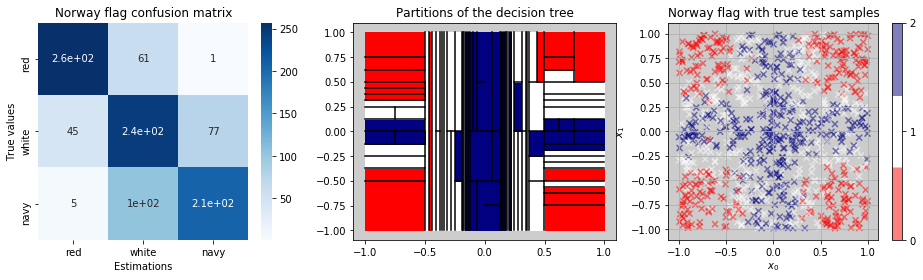

In [19]:
leafMinSize = leafSizeRange[bestParams // len(leafSizeRange)]
entropyMin = entropyRange[bestParams % len(leafSizeRange)]
model1Norway = MyTreeClassifier(leafMinSize=leafMinSize, entropyMin=entropyMin)
processedListN1 = model1Norway.fit(xTrainN, yTrainN, range(3))
yEstN1 = model1Norway.predict(xTestN)

print("Norway flag classification with leaf min size = %d, min entropy = %.3f" % (leafMinSize, entropyMin))
print(metrics.classification_report(yTestN, yEstN1))

fig, axes = plt.subplots(1, 3, figsize=(16, 4))
plotConfusionMatrix(yTestN, yEstN1, norwayColors, ax=axes[0], title="Norway flag confusion matrix")
axes[1].set_title("Partitions of the decision tree")
axes[1].set_facecolor((0.8, 0.8, 0.8))
for targetDepth in range(1, 10):
    for n in filter(lambda n: n.depth == targetDepth, processedListN1):
        plotNodeArea(n, norwayColors, axes[1])
flagPlot(xTestN, yTestN, "Norway flag with true test samples", norwayColors, ax=axes[2])

The minimum entropy stop criteria has the advantage of avoid very fine and small partitions and thus decrease the need of consolidating the leafs (also called pruning). However it may also prevent useful splits at the early stages as seen on the large white rectangles at right hand of above partition map.

Comparing the partition map based on the training samples and the plot of the test samples, we see that there is some overfitting.

## Classification tree with Scikit-Learn

In [20]:
model2Norway = tree.DecisionTreeClassifier(min_samples_leaf=8, criterion='entropy')
model2Norway.fit(xTrainN, yTrainN)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=8, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

Norway flag classification with leaf min size = 8
              precision    recall  f1-score   support

         0.0       0.87      0.82      0.84       319
         1.0       0.62      0.60      0.61       366
         2.0       0.67      0.74      0.71       315

    accuracy                           0.71      1000
   macro avg       0.72      0.72      0.72      1000
weighted avg       0.72      0.71      0.71      1000



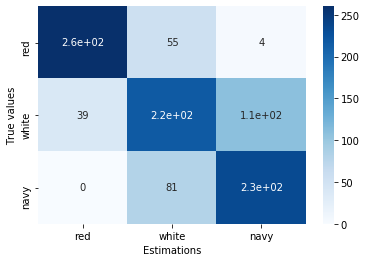

In [21]:
yEstN2 = model2Norway.predict(xTestN)
print("Norway flag classification with leaf min size = 8")
print(metrics.classification_report(yTestN, yEstN2))

plotConfusionMatrix(yTestN, yEstN2, norwayColors)

### Visualization of the decision tree

Scikit-Learn provides a graph view of the Tree... not that easy to visualize

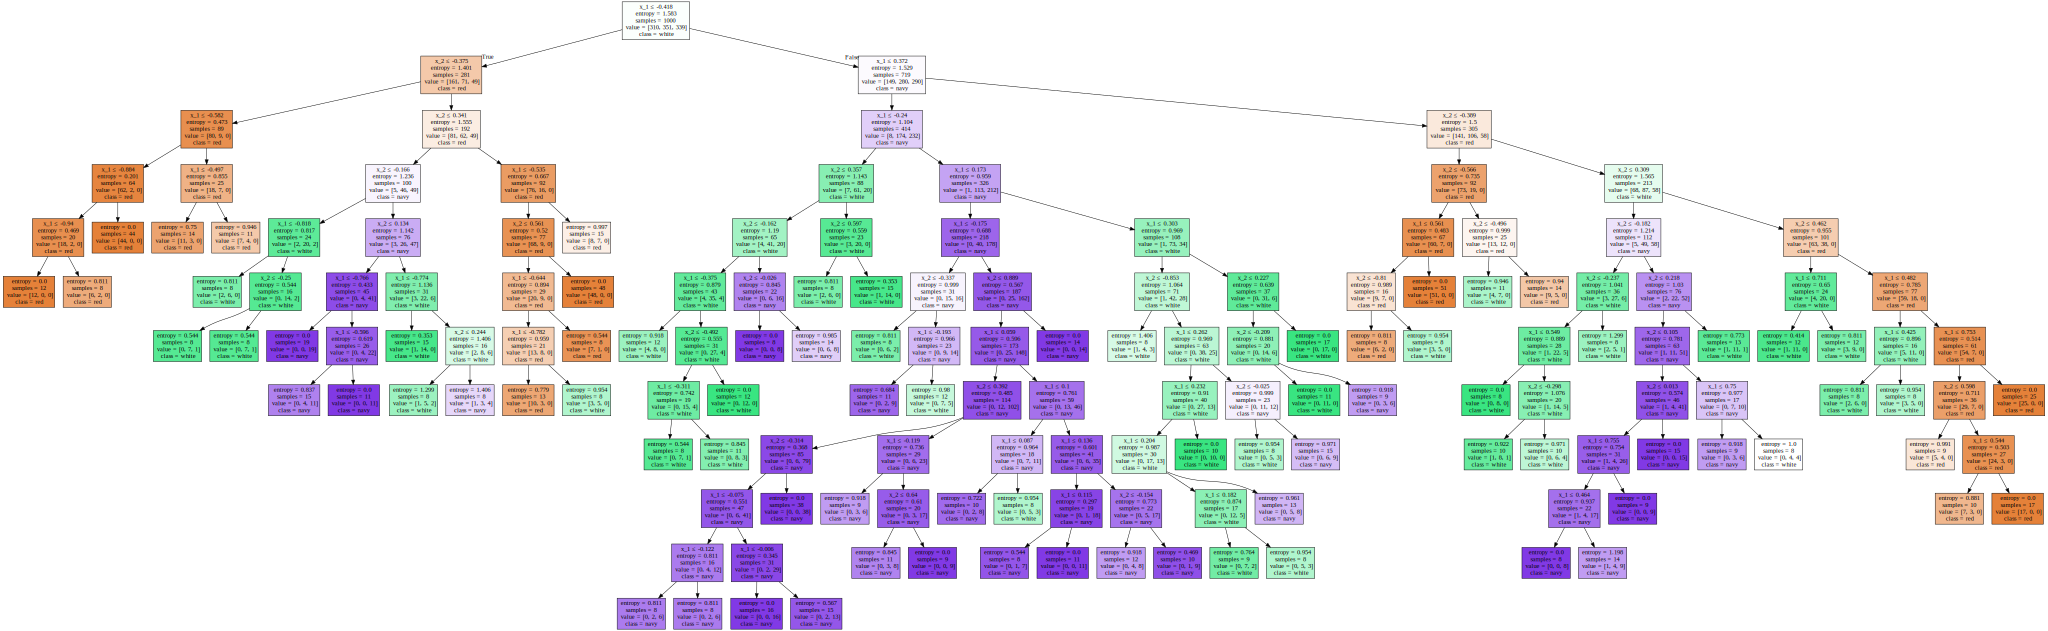

In [31]:
dot_data = tree.export_graphviz(model2Norway, out_file=None, 
                    feature_names=['x_1','x_2'],  
                    class_names=norwayColors,  
                    filled=True, rounded=False,  
                    special_characters=True)  
graph = graphviz.Source(dot_data)  
display(SVG(graph.pipe(format='svg')))

## Conclusion

Tree classifier provides a simple algorithm that is able to cope with non linearly separable problems like Norway flag.

Its performance, as measured by the F1-score or accuracy, is very close to the one achieved by neural networks (see [HTML](ClassificationMulti2Features-Keras.html) / [Jupyter](ClassificationMulti2Features-Keras.ipynb)) but the design cost is way lower. The prediction cost might also be lower as well : it requires maximum $d = log_2(N)$ comparisons where $d$ is the depth and $N$ the number of leaves of the tree.

### Where to go from here

- Same multi-class problem but using neural networks and the Keras framework ([HTML](ClassificationMulti2Features-Keras.html) / [Jupyter](ClassificationMulti2Features-Keras.ipynb))
- Binary classification with Logistic regression ([HTML](ClassificationContinuous2Features-KNN.html) / [Jupyter](ClassificationContinuous2Features.ipynb)), or k Nearest Neighbors ([HTML](ClassificationContinuous2Features.html) / [Jupyter](ClassificationContinuous2Features-KNN.ipynb))